In [43]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np

In [19]:
survey2021 = pd.read_csv('CSV_DATA/RawData/2021.csv') 
survey2019 = pd.read_csv('CSV_DATA/RawData/2019.csv')
survey2017 = pd.read_csv('CSV_DATA/RawData/2017.csv')

In [20]:
def filter_survey_data(df):
    """
    Filters the survey data to include only full-time, U.S.-based workers with a bachelor’s degree 
    within certain age and work-hour limits, excluding specific employment types.
    Parameters:
    - df (DataFrame): The input survey data.
    Returns:
    - DataFrame: The filtered survey data.
    """
    # Step 1: Filter by bachelor's degree indicator, filtering those missing Carnegie classification and degree type
    df_filtered = df[(df['BAIND'] == 'Y') & (df['NBAMEMG'] != "L") & (~df['BACARN'].isin(['L', 'M']))]
    
    # Step 2: Filter by age range (22-65)
    df_filtered = df_filtered[(df_filtered['AGE'] >= 22) & (df_filtered['AGE'] <= 65)]
    
    # Step 3: Filter by work hours (35-85 hours per week)
    df_filtered = df_filtered[(df_filtered['HRSWK'] >= 35) & (df_filtered['HRSWK'] <= 85)]
    
    # Step 4: Exclude full-time student 
    df_filtered = df_filtered[df_filtered['ACFPT'] != 'Y']
    
    # Step 5: Exclude specific employment types
    df_filtered = df_filtered[(df_filtered['EMTP'] != 16) & 
                              (df_filtered['EMTP'] != 12) & 
                              (df_filtered['EMUS'] == 'Y')]
    return df_filtered 
    

In [21]:
#Apply the filtering on survey data 
filter2021 = filter_survey_data(survey2021) 
filter2019 = filter_survey_data(survey2019)  
filter2017 = filter_survey_data(survey2017) 

In [6]:
summary = filter2017[['OCEDRLP']].value_counts()
print(summary)

OCEDRLP
1          28609
2          12179
3           5915
dtype: int64


In [40]:
def weighted_median(data, weights):
    """Calculate the weighted median of a dataset."""
    sorted_data, sorted_weights = zip(*sorted(zip(data, weights)))
    cumulative_weight = np.cumsum(sorted_weights)
    cutoff = cumulative_weight[-1] / 2
    return sorted_data[np.searchsorted(cumulative_weight, cutoff)]

def calculate_summary_by_year(df, year):
    carnegie_mapping = {
        11: 'Research', 12: 'Research',
        13: 'Doctorate Granting', 14: 'Doctorate Granting',
        21: 'Comprehensive', 22: 'Comprehensive',
        31: 'Liberal Arts', 32: 'Liberal Arts',
        40: 'Specialized', 51: 'Specialized', 52: 'Specialized',
        53: 'Specialized', 54: 'Specialized', 56: 'Specialized',
        59: 'Specialized', 60: 'Specialized'
    }

    # Ensure columns are numeric where needed
    df['BACARN'] = pd.to_numeric(df['BACARN'], errors='coerce')
    df['OCEDRLP'] = pd.to_numeric(df['OCEDRLP'], errors='coerce')
    df['WTSURVY'] = pd.to_numeric(df['WTSURVY'], errors='coerce')
    df['SALARY'] = pd.to_numeric(df['SALARY'], errors='coerce')

    # Map Carnegie Classification
    df['Carnegie_Group'] = df['BACARN'].map(carnegie_mapping)

    # Assign Match_Status
    df['Match_Status'] = df['OCEDRLP'].map({1: 'Match', 2: 'Match', 3: 'Unmatch'})

    # Initialize summary dictionary
    summary = {
        f'{year}_Match': {},
        f'{year}_Unmatch': {}
    }

    for status in ['Match', 'Unmatch']:
        subset = df[df['Match_Status'] == status]
        weights = subset['WTSURVY']
        # Calculate weighted metrics
        summary[f'{year}_{status}'] = {
            'Somewhat_related': ((subset['OCEDRLP'] == 2) * weights).sum() / weights.sum() * 100,
            'Men': ((subset['GENDER'] == 'M') * weights).sum() / weights.sum() * 100,
            'Salary_Mean': (subset['SALARY'] * weights).sum() / weights.sum(),
            'Salary_Median': weighted_median(subset['SALARY'], weights),
            'Bachelor': ((subset['DGRDG'] == 1) * weights).sum() / weights.sum() * 100,
            'Master': ((subset['DGRDG'] == 2) * weights).sum() / weights.sum() * 100,
            'PhD': ((subset['DGRDG'] == 3) * weights).sum() / weights.sum() * 100,
            'Comp_Math_Sci': ((subset['NBAMEMG'] == 1) * weights).sum() / weights.sum() * 100,
            'Bio_Agri_Life_Sci': ((subset['NBAMEMG'] == 2) * weights).sum() / weights.sum() * 100,
            'Phys_Sci': ((subset['NBAMEMG'] == 3) * weights).sum() / weights.sum() * 100,
            'Social_Sci': ((subset['NBAMEMG'] == 4) * weights).sum() / weights.sum() * 100,
            'Engineering': ((subset['NBAMEMG'] == 5) * weights).sum() / weights.sum() * 100,
            'S_E_Related': ((subset['NBAMEMG'] == 6) * weights).sum() / weights.sum() * 100,
            'Non_S_E': ((subset['NBAMEMG'] == 7) * weights).sum() / weights.sum() * 100,
            'US_Citizen': ((subset['CTZUSIN'] == 'Y') * weights).sum() / weights.sum() * 100,
            'Non_US_Citizen': ((subset['CTZUSIN'] == 'N') * weights).sum() / weights.sum() * 100,
            'Asian': ((subset['RACETHM'] == 1) * weights).sum() / weights.sum() * 100,
            'American_Indian_Alaska_Native': ((subset['RACETHM'] == 2) * weights).sum() / weights.sum() * 100,
            'Black': ((subset['RACETHM'] == 3) * weights).sum() / weights.sum() * 100,
            'Hispanic': ((subset['RACETHM'] == 4) * weights).sum() / weights.sum() * 100,
            'White': ((subset['RACETHM'] == 5) * weights).sum() / weights.sum() * 100,
            'Native_Hawaiian_Other_Pacific_Islander': ((subset['RACETHM'] == 6) * weights).sum() / weights.sum() * 100,
            'Multiple_Race': ((subset['RACETHM'] == 7) * weights).sum() / weights.sum() * 100,
            'Research': ((subset['Carnegie_Group'] == 'Research') * weights).sum() / weights.sum() * 100,
            'Doctorate_Granting': ((subset['Carnegie_Group'] == 'Doctorate Granting') * weights).sum() / weights.sum() * 100,
            'Comprehensive': ((subset['Carnegie_Group'] == 'Comprehensive') * weights).sum() / weights.sum() * 100,
            'Liberal_Arts': ((subset['Carnegie_Group'] == 'Liberal Arts') * weights).sum() / weights.sum() * 100,
            'Specialized': ((subset['Carnegie_Group'] == 'Specialized') * weights).sum() / weights.sum() * 100,
        }

    return pd.DataFrame(summary)

# Test the function for each year
summary_2017 = calculate_summary_by_year(filter2017, '2017')
summary_2019 = calculate_summary_by_year(filter2019, '2019')
summary_2021 = calculate_summary_by_year(filter2021, '2021')

summary_table = pd.concat([summary_2017, summary_2019, summary_2021], axis=1)


In [41]:
summary_table

,2017_Match,2017_Unmatch,2019_Match,2019_Unmatch,2021_Match,2021_Unmatch
Somewhat_related,34.224695,0.000000,33.764838,0.000000,34.267805,0.000000
Men,49.428126,51.021921,48.993627,51.004459,49.340790,53.168886
Salary_Mean,95658.086984,69368.178662,95203.459888,68968.489265,99232.327031,72995.454360
Salary_Median,72000.000000,50000.000000,75000.000000,55000.000000,80000.000000,58469.000000
Bachelor,61.237260,84.023432,61.295239,83.749746,61.694219,84.531651
Master,28.802508,14.239566,29.172201,14.408452,28.440343,13.635167
PhD,3.217613,0.639093,3.465635,0.711765,3.423041,0.552993
Comp_Math_Sci,5.585876,3.839222,6.125471,2.764815,6.645276,3.537492
Bio_Agri_Life_Sci,7.349334,6.917484,7.369653,6.912931,7.763808,7.162591
Phys_Sci,2.166645,2.201190,2.378075,2.123965,2.246041,2.216450


In [34]:

# Define a function to calculate weighted percentages for each reason in a given year
def calculate_reason_percentage(df, year):
    # Define the reason descriptions based on the 'NRREA' values, excluding 'L'
    reason_descriptions = {
        1: "Pay, promotion opportunities",
        2: "Working conditions",
        3: "Job location",
        4: "Change in career or professional interests",
        5: "Family-related reasons",
        6: "Job in highest degree field not available",
        7: "Other reason for not working"
    }

    # Convert 'NRREA' and 'WTSURVY' to numeric, handling any potential non-numeric values
    df['NRREA'] = pd.to_numeric(df['NRREA'], errors='coerce')
    df['WTSURVY'] = pd.to_numeric(df['WTSURVY'], errors='coerce')

    # Filter out rows where 'NRREA' is not in the defined reasons (1 to 7) or is NaN
    df = df[df['NRREA'].isin(reason_descriptions.keys())]
    # Calculate weighted count for each reason
    weighted_counts = df.groupby('NRREA')['WTSURVY'].sum()

    # Calculate total weight sum
    total_weight = weighted_counts.sum()
    # Calculate the weighted percentage for each reason
    weighted_percentage = (weighted_counts / total_weight) * 100

    # Map reason descriptions to the percentage results
    reason_percentage = pd.DataFrame({
        'Reason': [reason_descriptions.get(reason, 'Unknown') for reason in weighted_percentage.index],
        year: weighted_percentage.values
    })
    
    # Return the DataFrame with 'Reason' as index
    return reason_percentage.set_index('Reason')

# Calculate the percentages for each year
percent_2017 = calculate_reason_percentage(filter2017, '2017')
percent_2019 = calculate_reason_percentage(filter2019, '2019')
percent_2021 = calculate_reason_percentage(filter2021, '2021')

# Combine results for all years into a single DataFrame
percent_table = pd.concat([percent_2017, percent_2019, percent_2021], axis=1)


In [35]:
percent_table

,2017,2019,2021
Reason,,,
"Pay, promotion opportunities",30.799310,31.170155,32.290056
Working conditions,13.734722,11.007588,12.148760
Job location,7.717986,7.812965,6.231131
Change in career or professional interests,15.639123,19.176088,18.716396
Family-related reasons,9.492099,9.057586,8.376374
Job in highest degree field not available,15.915588,15.392947,15.160052
Other reason for not working,6.701172,6.382671,7.077232


In [76]:
def prepare_satisfaction_data(df, year):
    # Define mappings for job match status and satisfaction levels
    job_match_mapping = {'1': 'Closely related', '2': 'Somewhat related', '3': 'Not related'}
    satisfaction_mapping = {
        '1': 'Very satisfied', 
        '2': 'Somewhat satisfied', 
        '3': 'Somewhat dissatisfied', 
        '4': 'Very dissatisfied'
    }

    # Map job match status and job satisfaction levels
    df['Job_Match_Status'] = df['OCEDRLP'].astype(str).map(job_match_mapping)
    df['Job_Satisfaction'] = df['JOBSATIS'].astype(str).map(satisfaction_mapping)

    # Drop rows with NaN in Job_Satisfaction or Job_Match_Status or WTSURVY
    df = df.dropna(subset=['Job_Satisfaction', 'Job_Match_Status', 'WTSURVY'])
    
    # Ensure WTSURVY is numeric
    df['WTSURVY'] = pd.to_numeric(df['WTSURVY'], errors='coerce')
    
    # Check for rows with NaN in WTSURVY and drop them
    df = df.dropna(subset=['WTSURVY'])

    # Group by job match status and satisfaction, and calculate weighted sum
    satisfaction_summary = df.groupby(['Job_Match_Status', 'Job_Satisfaction'])['WTSURVY'].sum().reset_index()

    # Calculate the percentage within each job match status group
    satisfaction_summary['Percentage'] = satisfaction_summary.groupby('Job_Match_Status')['WTSURVY'].apply(lambda x: (x / x.sum()) * 100)
    satisfaction_summary['Year'] = year

    return satisfaction_summary[['Job_Match_Status', 'Job_Satisfaction', 'Percentage', 'Year']]

# Prepare data for each year
data_2017 = prepare_satisfaction_data(filter2017, '2017')
data_2019 = prepare_satisfaction_data(filter2019, '2019')
data_2021 = prepare_satisfaction_data(filter2021, '2021')

# Combine the data from each year
combined_data = pd.concat([data_2017, data_2019, data_2021]) 
# Pivot the data to create a table with Job_Satisfaction levels as columns
combined_data_pivot = combined_data.pivot_table(
    index=['Job_Match_Status', 'Year'],
    columns='Job_Satisfaction',
    values='Percentage'
) 
combined_data_pivot

Job_Satisfaction       Somewhat dissatisfied  Somewhat satisfied  \
Job_Match_Status Year                                              
Closely related  2017               6.956191           40.750456   
                 2019               6.171186           42.658435   
                 2021               7.068482           43.430751   
Not related      2017              14.855849           45.086994   
                 2019              12.117656           49.643568   
                 2021              12.562463           44.771331   
Somewhat related 2017               9.978544           48.034687   
                 2019               9.189428           48.305870   
                 2021               9.732007           48.577580   

Job_Satisfaction       Very dissatisfied  Very satisfied  
Job_Match_Status Year                                     
Closely related  2017           1.508961       50.784391  
                 2019           1.492187       49.678193  
                 2021           1.398625       48.102142  
Not related      2017           6.364239       33.692919  
                 2019           5.659636       32.579140  
                 2021           5.764849       36.901357  
Somewhat related 2017           2.258597       39.728172  
                 2019           1.954148       40.550554  
                 2021           2.305977       39.384436

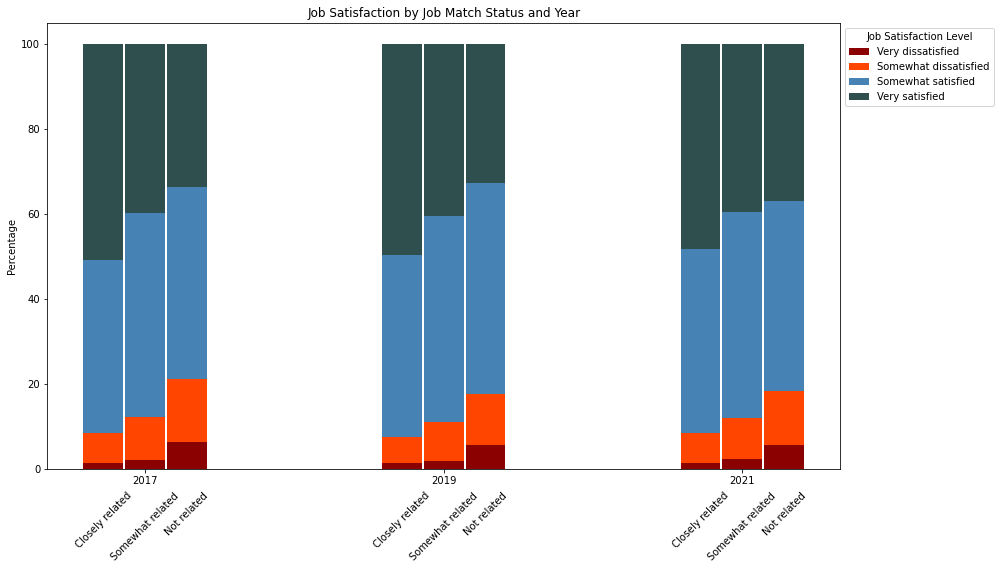

In [79]:
# Define colors for satisfaction levels in the desired order (from dissatisfaction to satisfaction)
satisfaction_colors = {
    'Very dissatisfied': '#8B0000',  # Dark red for very dissatisfied
    'Somewhat dissatisfied': '#FF4500',  # Orange for somewhat dissatisfied
    'Somewhat satisfied': '#4682B4',  # Steel blue for somewhat satisfied
    'Very satisfied': '#2F4F4F'  # Dark slate gray for very satisfied
}

# Define job match statuses and years
job_match_statuses = ["Closely related", "Somewhat related", "Not related"]
years = ['2017', '2019', '2021']

# Width for each individual bar
bar_width = 0.2  
# Separation width between year groups and within each year for job match statuses
year_gap = 1.5  
status_gap = 0.01  

# Set up x positions for each year group
year_positions = np.arange(len(years)) * year_gap

# Set up figure
fig, ax = plt.subplots(figsize=(14, 8))

# Loop over each year and job match status
for i, year in enumerate(years):
    for j, status in enumerate(job_match_statuses):
        # Calculate the x position for each job match status within a year group
        x_pos = year_positions[i] + j * (bar_width + status_gap)

        # Collect the data for this bar (for each satisfaction level in the specified order)
        bar_data = [
            combined_data_pivot.loc[(status, year), 'Very dissatisfied'],
            combined_data_pivot.loc[(status, year), 'Somewhat dissatisfied'],
            combined_data_pivot.loc[(status, year), 'Somewhat satisfied'],
            combined_data_pivot.loc[(status, year), 'Very satisfied']
        ]
        
        # Stack the bars for each satisfaction level with the correct color mapping
        bottom = 0
        for satisfaction_level, value in zip(satisfaction_colors.keys(), bar_data):
            color = satisfaction_colors[satisfaction_level]
            ax.bar(x_pos, value, bar_width, bottom=bottom, color=color, 
                   label=satisfaction_level if i == 0 and j == 0 else "")
            bottom += value  # Update the bottom for stacking

        # Add a label below each set of bars to show the job match status
        ax.text(x_pos, -5, status, ha='center', va='top', rotation=45, fontsize=10)

# Set x-tick positions and labels for each year
x_tick_positions = year_positions + bar_width + status_gap  # Center x-ticks between the groups
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(years)

# Set labels and title
ax.set_ylabel("Percentage")
ax.set_title("Job Satisfaction by Job Match Status and Year")

# Arrange the legend in the specified order and position
handles, labels = ax.get_legend_handles_labels()
order = [0, 1, 2, 3]  # Order legend from Very dissatisfied to Very satisfied
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          title="Job Satisfaction Level", loc='upper left', bbox_to_anchor=(1, 1))

# Ensure layout fits well
plt.tight_layout()
plt.show()

In [81]:
filter2021.to_csv('CSV_DATA/CleanData/filter2021.csv')
filter2019.to_csv('CSV_DATA/CleanData/filter2019.csv')
filter2017.to_csv('CSV_DATA/CleanData/filter2017.csv')